In [1]:
import pandas 
import numpy as np
import copy
import datetime as dt
import argparse
import netCDF4 as nc
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import matplotlib.ticker as mticker
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as mcolors
import matplotlib
from matplotlib.path import Path
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

Could not save font_manager cache [Errno 28] No space left on device


In [2]:
def calc_w_from_convergence(u_var, v_var, wrapx = True):
    
    # Work timelevel by timelevel
    ntime, nk, nlat, nlon = u_var.shape
    w = np.ma.zeros( (ntime, nk+1, nlat, nlon-1)  )
    
    for tidx in range(ntime):
        # Get and process the u component
        u_dat = u_var[tidx,:,:,:]
        u_dat = u_dat.filled(0.)
        
        # Get and process the v component
        v_dat = v_var[tidx,:,:,:]
        v_dat = v_dat.filled(0.)

        # Order of subtraction based on upwind sign convention and desire for w>0 to correspond with upwards velocity
        w[tidx,:-1,:,:] += u_dat[:,:,:-1] - u_dat[:,:,1:]
        w[tidx,:-1,:,:] += v_dat[:,:-1,:] - v_dat[:,1:,:]

        # Do a double-flip so that we integrate from the bottom
        w[tidx,:-1,:,:] = w[tidx,-2::-1,:,:].cumsum(axis=0)[::-1,:,:]
            
    return w

In [3]:
def convert_nep_time(time):
    ref = dt.datetime(1993,1,1,0,0,0)
    date_vals = np.zeros(len(time))
    for nt in range(len(time)):
        day_time = ref + dt.timedelta(days=np.float(time[nt]))
        date_vals[nt] = pltd.date2num(day_time)
            
    return date_vals

In [4]:
def deg_dist_offshore(lat):
    delta_lon = dist_offshore/(111.320*np.cos(lat*(np.pi/180)))
    
    return delta_lon

In [5]:
def define_points(clat):
    # indeces above the upper and lower bounds of the box
    lat_s = clat-.5
    lat_n = clat+.5
    
    idx_s = np.argmax(y_ccs>lat_s)
    idx_n = np.argmax(y_ccs>lat_n)

    # y distance around southern bound
    s_lat_dist = y_ccs[idx_s] - y_ccs[idx_s-1]

    # weight for northern point: distance from southern bounds to point below 
    s_weight_n = (lat_s - y_ccs[idx_s-1])/s_lat_dist 
    # weight for southern point: distance from point above to southern bounds
    s_weight_s = (y_ccs[idx_s]-lat_s)/s_lat_dist
    # Interpolated position
    x_s = s_weight_n*x_ccs[idx_s] + s_weight_s*x_ccs[idx_s-1]

    # y distance around northern bound
    n_lat_dist = y_ccs[idx_n] - y_ccs[idx_n-1]
    # weight for northern point: distance from northerm bounds to point below 
    n_weight_n = (lat_n - y_ccs[idx_n-1])/n_lat_dist 
    # weight for southern point: distance from point above to southern bounds
    n_weight_s = (y_ccs[idx_n]-lat_n)/n_lat_dist
    # Interpolated position
    x_n = n_weight_n*x_ccs[idx_n] + n_weight_s*x_ccs[idx_n-1]

    # Moved alongshore bounds inland .4 degrees because coarse (110m) matplotlib coastline excludes a few points close to shore
    x_all = np.hstack((x_s+.4,x_ccs[idx_s:idx_n]+.4,x_n+.4,
                       x_n-deg_dist_offshore(lat_n),
                       np.array([x-deg_dist_offshore(lat) for x,lat in zip(x_ccs[idx_s:idx_n][::-1],y_ccs[idx_s:idx_n][::-1])]).squeeze(),
                       x_s-deg_dist_offshore(lat_s),x_s+.4))
    x_all[x_all<0] = x_all[x_all<0]+360
    
    y_all = np.hstack((lat_s,y_ccs[idx_s:idx_n],lat_n,
                       lat_n,
                       y_ccs[idx_s:idx_n][::-1],
                       lat_s,lat_s))
    
    points = np.hstack((x_all[:,np.newaxis],y_all[:,np.newaxis]))
    
    return points

    

In [6]:
def plot_box(clat,ax):
    # indeces above the upper and lower bounds of the box
    lat_s = clat-.5
    lat_n = clat+.5
    
    idx_s = np.argmax(y_ccs>lat_s)
    idx_n = np.argmax(y_ccs>lat_n)

    # y distance around southern bound
    s_lat_dist = y_ccs[idx_s] - y_ccs[idx_s-1]

    # weight for northern point: distance from southern bounds to point below 
    s_weight_n = (lat_s - y_ccs[idx_s-1])/s_lat_dist 
    # weight for southern point: distance from point above to southern bounds
    s_weight_s = (y_ccs[idx_s]-lat_s)/s_lat_dist
    # Interpolated position
    x_s = s_weight_n*x_ccs[idx_s] + s_weight_s*x_ccs[idx_s-1]

    # y distance around northern bound
    n_lat_dist = y_ccs[idx_n] - y_ccs[idx_n-1]
    # weight for northern point: distance from northerm bounds to point below 
    n_weight_n = (lat_n - y_ccs[idx_n-1])/n_lat_dist 
    # weight for southern point: distance from point above to southern bounds
    n_weight_s = (y_ccs[idx_n]-lat_n)/n_lat_dist
    # Interpolated position
    x_n = n_weight_n*x_ccs[idx_n] + n_weight_s*x_ccs[idx_n-1]

    # Moved alongshore bounds inland .4 degrees because coarse (110m) matplotlib coastline excludes a few points close to shore
    x_all = np.hstack((x_s+.4,x_ccs[idx_s:idx_n]+.4,x_n+.4,
                       x_n-deg_dist_offshore(lat_n),
                       np.array([x-deg_dist_offshore(lat) for x,lat in zip(x_ccs[idx_s:idx_n][::-1],y_ccs[idx_s:idx_n][::-1])]).squeeze(),
                       x_s-deg_dist_offshore(lat_s),x_s+.4))
    x_all[x_all<0] = x_all[x_all<0]+360
    
    y_all = np.hstack((lat_s,y_ccs[idx_s:idx_n],lat_n,
                       lat_n,
                       y_ccs[idx_s:idx_n][::-1],
                       lat_s,lat_s))
    
    points = np.hstack((x_all[:,np.newaxis],y_all[:,np.newaxis]))
    poly_path=Path(points)
    poly_corners = points

    poly = mpatches.Polygon(poly_corners,closed=True, ec='black', fill=False, 
                            lw=1, fc=None, transform=ccrs.PlateCarree())
    ax.add_patch(poly)

In [7]:
def plt_clim_ts():
    
    # create axes - goes from top to bottom
    ax_clim = fig.add_subplot(spec[nplot,1])
    ax_anom = fig.add_subplot(spec[nplot,-1])
    
    # access the comparison timeseries
    nep_ts = tmp_cuti_stor[nlat,:]
    roms_ts = monthly_df[(str(int(clat)) + 'N')]
    
    # calculate linear regression statistics
    slope, intercept, r, p, se = stats.linregress(nep_ts, roms_ts)
    corr = stats.pearsonr(nep_ts, roms_ts)
    print(corr)
    
    
    # calculate monthly climatology
    nep_clim = np.mean(nep_ts.reshape(-1,12),axis=0)
    roms_clim = np.mean(np.array(roms_ts).reshape(-1,12),axis=0)
    
    # calculate linear regression statistics
    slope, intercept, r, p, se = stats.linregress(nep_clim, roms_clim)
    corr = stats.pearsonr(nep_clim, roms_clim)
    print(corr)
    ax_clim.plot(nep_clim,'-', label = 'NEP10k')
    ax_clim.plot(roms_clim,'-', label = 'ROMS CUTI')
    
    #ax_clim.text(.7,.9,('R = ' + f'{r:.2f}'),transform=ax_clim.transAxes)
    ax_clim.text(.7,.9,('R = ' + f'{corr[0]:.2f}'),transform=ax_clim.transAxes)
    
    # calculate monthly anomaly
    nep_anom = (nep_ts.reshape(-1,12) - nep_clim).ravel()
    roms_anom = (np.array(roms_ts).reshape(-1,12) - roms_clim).ravel()
    
    # calculate linear regression statistics
    slope, intercept, r, p, se = stats.linregress(nep_anom, roms_anom)
    corr = stats.pearsonr(nep_anom, roms_anom)
    print(corr)
    
    ax_anom.plot(plt_time,nep_anom,'-', label = 'NEP10k')
    ax_anom.plot(plt_time,roms_anom,'-', label = 'ROMS CUTI')
    
    ax_anom.xaxis_date()
    
    #ax_anom.text(.85,.9,('R = ' + f'{r:.2f}'),transform=ax_anom.transAxes)
    ax_anom.text(.85,.9,('R = ' + f'{corr[0]:.2f}'),transform=ax_anom.transAxes)
    ax_anom.set_xlim(plt_time[0],plt_time[-1])

    # Latitude title
    ax_clim.text(.03,.87,(str(int(clat)) + 'N'),weight = 'bold', fontsize=12,transform=ax_clim.transAxes)
    ax_clim.set_xlim(0,11)
    if nplot < 4:
    
        ax_clim.set_xticklabels([])
        ax_anom.set_xticklabels([])
        
        if nplot == 0: 
            ax_clim.legend()#loc='upper right')
            ax_clim.set_title('Climatology')
            ax_anom.set_title('Monthly Anomalies')
            
        elif nplot == 2:
            ax_clim.set_ylabel('Transport (m$^{2}$ s$^{-1}$)',labelpad=10,fontsize=15)
        
    else:
        
        ax_clim.set_xlabel('Month')
        ax_clim.set_xticks(np.arange(0,12,2))
        ax_clim.set_xticklabels(months[::2])

        ax_anom.set_xlabel('Year')
        
        
        

In [8]:
def plt_map():
    
    ax = fig.add_subplot(spec[:,0], projection=ccrs.PlateCarree(central_longitude=-100))

    gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True, linewidth=1, 
                  color='black', alpha=0.2, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-124, -120, -116])
    gl.ylocator = mticker.FixedLocator(np.arange(32,46+1,4))
    gl.xlabels_top = False
    gl.ylabels_right = False

    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)


    # spring and summer mean
    C = ax.pcolormesh(nep_clon,nep_clat,w,cmap='seismic',
                  vmin=-3,vmax=3,transform=ccrs.PlateCarree())

    # outline bins
    n=0
    for clat,lat_idx in zip(lat_centers,range(len(lat_centers))):
        plot_box(clat,ax)
       
    # land and coasts    
    ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
    ax.coastlines(zorder=50)
    ax.set_extent([234,244.5,30.3,47.7], crs=ccrs.PlateCarree())

    # place colorbar
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0+.6*pos.width, pos.y0+.55*pos.height, .05*pos.width, .3*pos.height])
    cbar = plt.colorbar(C,cax=cax)
    cax.set_title('Vertical Velocity \n (m day$^{-1}$)')
    plt.setp(ax.spines.values(), color='black',zorder=52)
    


In [9]:
csv_file = '/work/role.medgrp/NEP/plotting/Figure_24/CUTI_daily.csv'

df = pandas.read_csv(csv_file)
df = df[df.year >= 1993].reset_index(drop=True)
df = df[df.year <= 2019].reset_index(drop=True)
monthly_df = (df.groupby(['year', 'month'], as_index=False).mean())
monthly_df

,year,month,day,31N,32N,33N,34N,35N,36N,37N,38N,39N,40N,41N,42N,43N,44N,45N,46N,47N
0,1993,1,16.0,0.107903,0.070871,0.143839,0.046968,-0.067290,0.071806,0.014129,-0.329871,-0.055161,-0.470581,-0.176774,-0.376194,0.061581,-0.052806,-0.034871,-0.009290,-0.344161
1,1993,2,14.5,0.018214,0.040000,0.142393,0.154786,0.002643,-0.223571,-0.038000,-0.104714,-0.135250,0.089393,-0.060179,0.164643,0.067000,0.084393,-0.038750,-0.023964,-0.311286
2,1993,3,16.0,0.229710,0.409065,0.400839,0.585258,0.604129,0.601161,0.352806,0.261129,0.333710,0.268097,-0.221258,-0.302387,0.019323,-0.245097,-0.258903,-0.050742,-0.198710
3,1993,4,15.5,0.424033,0.498000,0.661567,1.161633,1.316400,1.177467,1.017667,0.758000,1.035833,0.752000,-0.042567,-0.056033,-0.365500,-0.466133,-0.467800,-0.154267,-0.471700
4,1993,5,16.0,0.393742,0.386065,0.505161,0.469387,0.302968,0.130161,0.109355,0.140742,0.188806,0.215290,-0.239806,0.007903,0.143194,-0.095452,0.033516,0.057581,-0.116323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2019,8,16.0,0.775419,0.659323,0.546000,0.866323,0.864290,0.855258,0.688000,0.343581,0.941742,1.107516,0.975032,0.766194,0.628000,0.415645,0.344774,0.295355,0.181484
320,2019,9,15.5,0.616200,0.403800,0.365933,0.721600,0.913633,0.988133,0.715467,0.713533,1.371467,1.174867,0.748267,0.726833,0.424200,0.224000,0.065367,0.187133,0.091567
321,2019,10,16.0,0.459161,0.331935,0.217935,0.400742,0.656129,0.733774,0.629452,0.389516,1.121097,0.817161,0.730581,0.828806,0.788645,0.283097,0.178129,0.119806,0.022129
322,2019,11,15.5,0.220767,0.157567,0.162567,0.243600,0.451233,0.519100,0.512900,0.435367,0.676800,0.651333,0.441833,0.356100,0.452567,0.417800,0.311033,0.266700,0.103067


In [10]:
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='physical',
                                      name='coastline')  
coastlines = shpreader.Reader(shpfilename).records()

#fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.PlateCarree()))
ncoast = 0
for c in coastlines: 
    if any(np.array(c.geometry.xy[1])<0) or any(np.array(c.geometry.xy[1])>72) or any(np.array(c.geometry.xy[0])>-55) or any(np.array(c.geometry.xy[0])<-170) or len(c.geometry.xy[0])<500:
        continue
    else:
        #print(len(c.geometry.xy[0]))
        #ax.plot(c.geometry.xy[0],c.geometry.xy[1])
        
        usa_geometry = c
        usa_y_110 = c.geometry.xy[1]
        usa_x_110 = c.geometry.xy[0]
   
    ncoast+=1

# Example offset of 2deg for CA coast for 110m resolution coastline
min_idx = 152
max_idx = 180

x_ccs = np.array(usa_x_110[min_idx:max_idx])
y_ccs = np.array(usa_y_110[min_idx:max_idx])

dist_offshore = 75# km offshore

In [11]:
plt_time = [pltd.date2num(dt.datetime(int(year),int(month),int(np.floor(day)),int(24*(day-np.floor(day))))) 
            for year,month,day in zip(monthly_df['year'],monthly_df['month'],monthly_df['day'])]


In [12]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/Figure_24/ccs_grid.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

coors=np.hstack((nep_lon.reshape(-1, 1), nep_lat.reshape(-1,1)))

In [13]:
cuti_dict = {'31': {'points': []},
             '32': {'points': []},
             '33': {'points': []},
             '34': {'points': []},
             '35': {'points': []},
             '36': {'points': []},
             '37': {'points': []},
             '38': {'points': []},
             '39': {'points': []},
             '40': {'points': []},
             '41': {'points': []},
             '42': {'points': []},
             '43': {'points': []},
             '44': {'points': []},
             '45': {'points': []},
             '46': {'points': []},
             '47': {'points': []},
              }

In [14]:
# single depth index, no depth interpolation
dep_idx = 6
#print(z_i[dep_idx], ' meters depth')

first_calc = True
lat_centers = np.arange(31,47+1)
all_years = range(1993,2019+1)

# number of bins x monthly timeseries length
cuti_storage = np.zeros((len(lat_centers),12*len(all_years)))

w_store = np.zeros(nep_lat.shape)
for year,nyr in zip(all_years,range(len(all_years))):
    print(year)
    ocean_fil = '/work/role.medgrp/NEP/plotting/Figure_24/ccs_umo_vmo_' + str(year) + '.nc'
    #ocean_fil = 'nep_umo_vmo_' + str(year) + '.nc'
    ocean_fid = nc.Dataset(ocean_fil)

    umo = ocean_fid.variables['umo'][:] # units kg s-1
    vmo = ocean_fid.variables['vmo'][:] # units kg s-1
    z_i = ocean_fid.variables['z_i'][:]
    
    # calculate wmo for whole domain
    wmo = calc_w_from_convergence(umo,vmo)
    
    if year>1993: 
        first_calc = False
        
    # conversion to upward volume transport by indexing to dep_idx and dividing by seawater density
    wvo = (wmo[:,dep_idx,:,:].squeeze()/1035.0) # conversion to "m3 per s" at specified depth level
    w_store += np.mean(wvo[2:8,:],axis=0)
    
    for cuti_bin,nbin in zip(lat_centers,range(len(lat_centers))):

        # isolate bin, sum wvo over bin area, divide by along-shore distance
        if first_calc:
            # assign points to cuti_dict
            cuti_dict[str(int(cuti_bin))]['points'] = define_points(cuti_bin)

        # bin summation
        poly_path=Path(cuti_dict[str(int(cuti_bin))]['points'])
        poly_mask = poly_path.contains_points(coors).reshape(nep_lon.shape[0],nep_lat.shape[1])
        
        tmp_area = np.ma.where((poly_mask==1)&(lsm>0),nep_area,np.nan)
        total_area = np.nansum(tmp_area)   
        area_weight = tmp_area/total_area
        
        tmp_wvo = np.ma.where((poly_mask==1)&(lsm>0),wvo,np.nan)
        # multiplying by the poly mask is PROBABLY redundant with above but also can't hurt
        cuti_storage[nbin,12*nyr:12*(nyr+1)] = np.nansum(poly_mask*tmp_wvo,axis=(2,1))/(111*1000) # convert to m2 s-1
        
# calculate time mean    
w_store = w_store/nyr
    
# just a single depth index, no depth interpolation
w = w_store/nep_area
w = w*(60*60*24) # conversion to "m per day"
                      

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


47 0
46 1
45 2
PearsonRResult(statistic=0.8739374913285631, pvalue=6.511623569999802e-103)
PearsonRResult(statistic=0.9753025259074042, pvalue=6.94307842079011e-08)
PearsonRResult(statistic=0.7123890391117269, pvalue=1.8678150925727533e-51)
44 3
43 4
42 5
PearsonRResult(statistic=0.8897357659444642, pvalue=1.0730431268083538e-111)
PearsonRResult(statistic=0.9878368341483823, pvalue=2.0542782156313978e-09)
PearsonRResult(statistic=0.755904817189027, pvalue=3.387637293346499e-61)
41 6
40 7
39 8
PearsonRResult(statistic=0.8319037946931906, pvalue=2.3396963486022108e-84)
PearsonRResult(statistic=0.977963499046582, pvalue=3.9440818234143164e-08)
PearsonRResult(statistic=0.5842129437635031, pvalue=4.86140917816093e-31)
38 9
37 10
36 11
PearsonRResult(statistic=0.7854914346973376, pvalue=4.4390827799772886e-69)
PearsonRResult(statistic=0.9344355546064936, pvalue=8.541498239866653e-06)
PearsonRResult(statistic=0.6043925130861232, pvalue=1.1985406619789333e-33)
35 12
34 13
33 14
PearsonRResult(

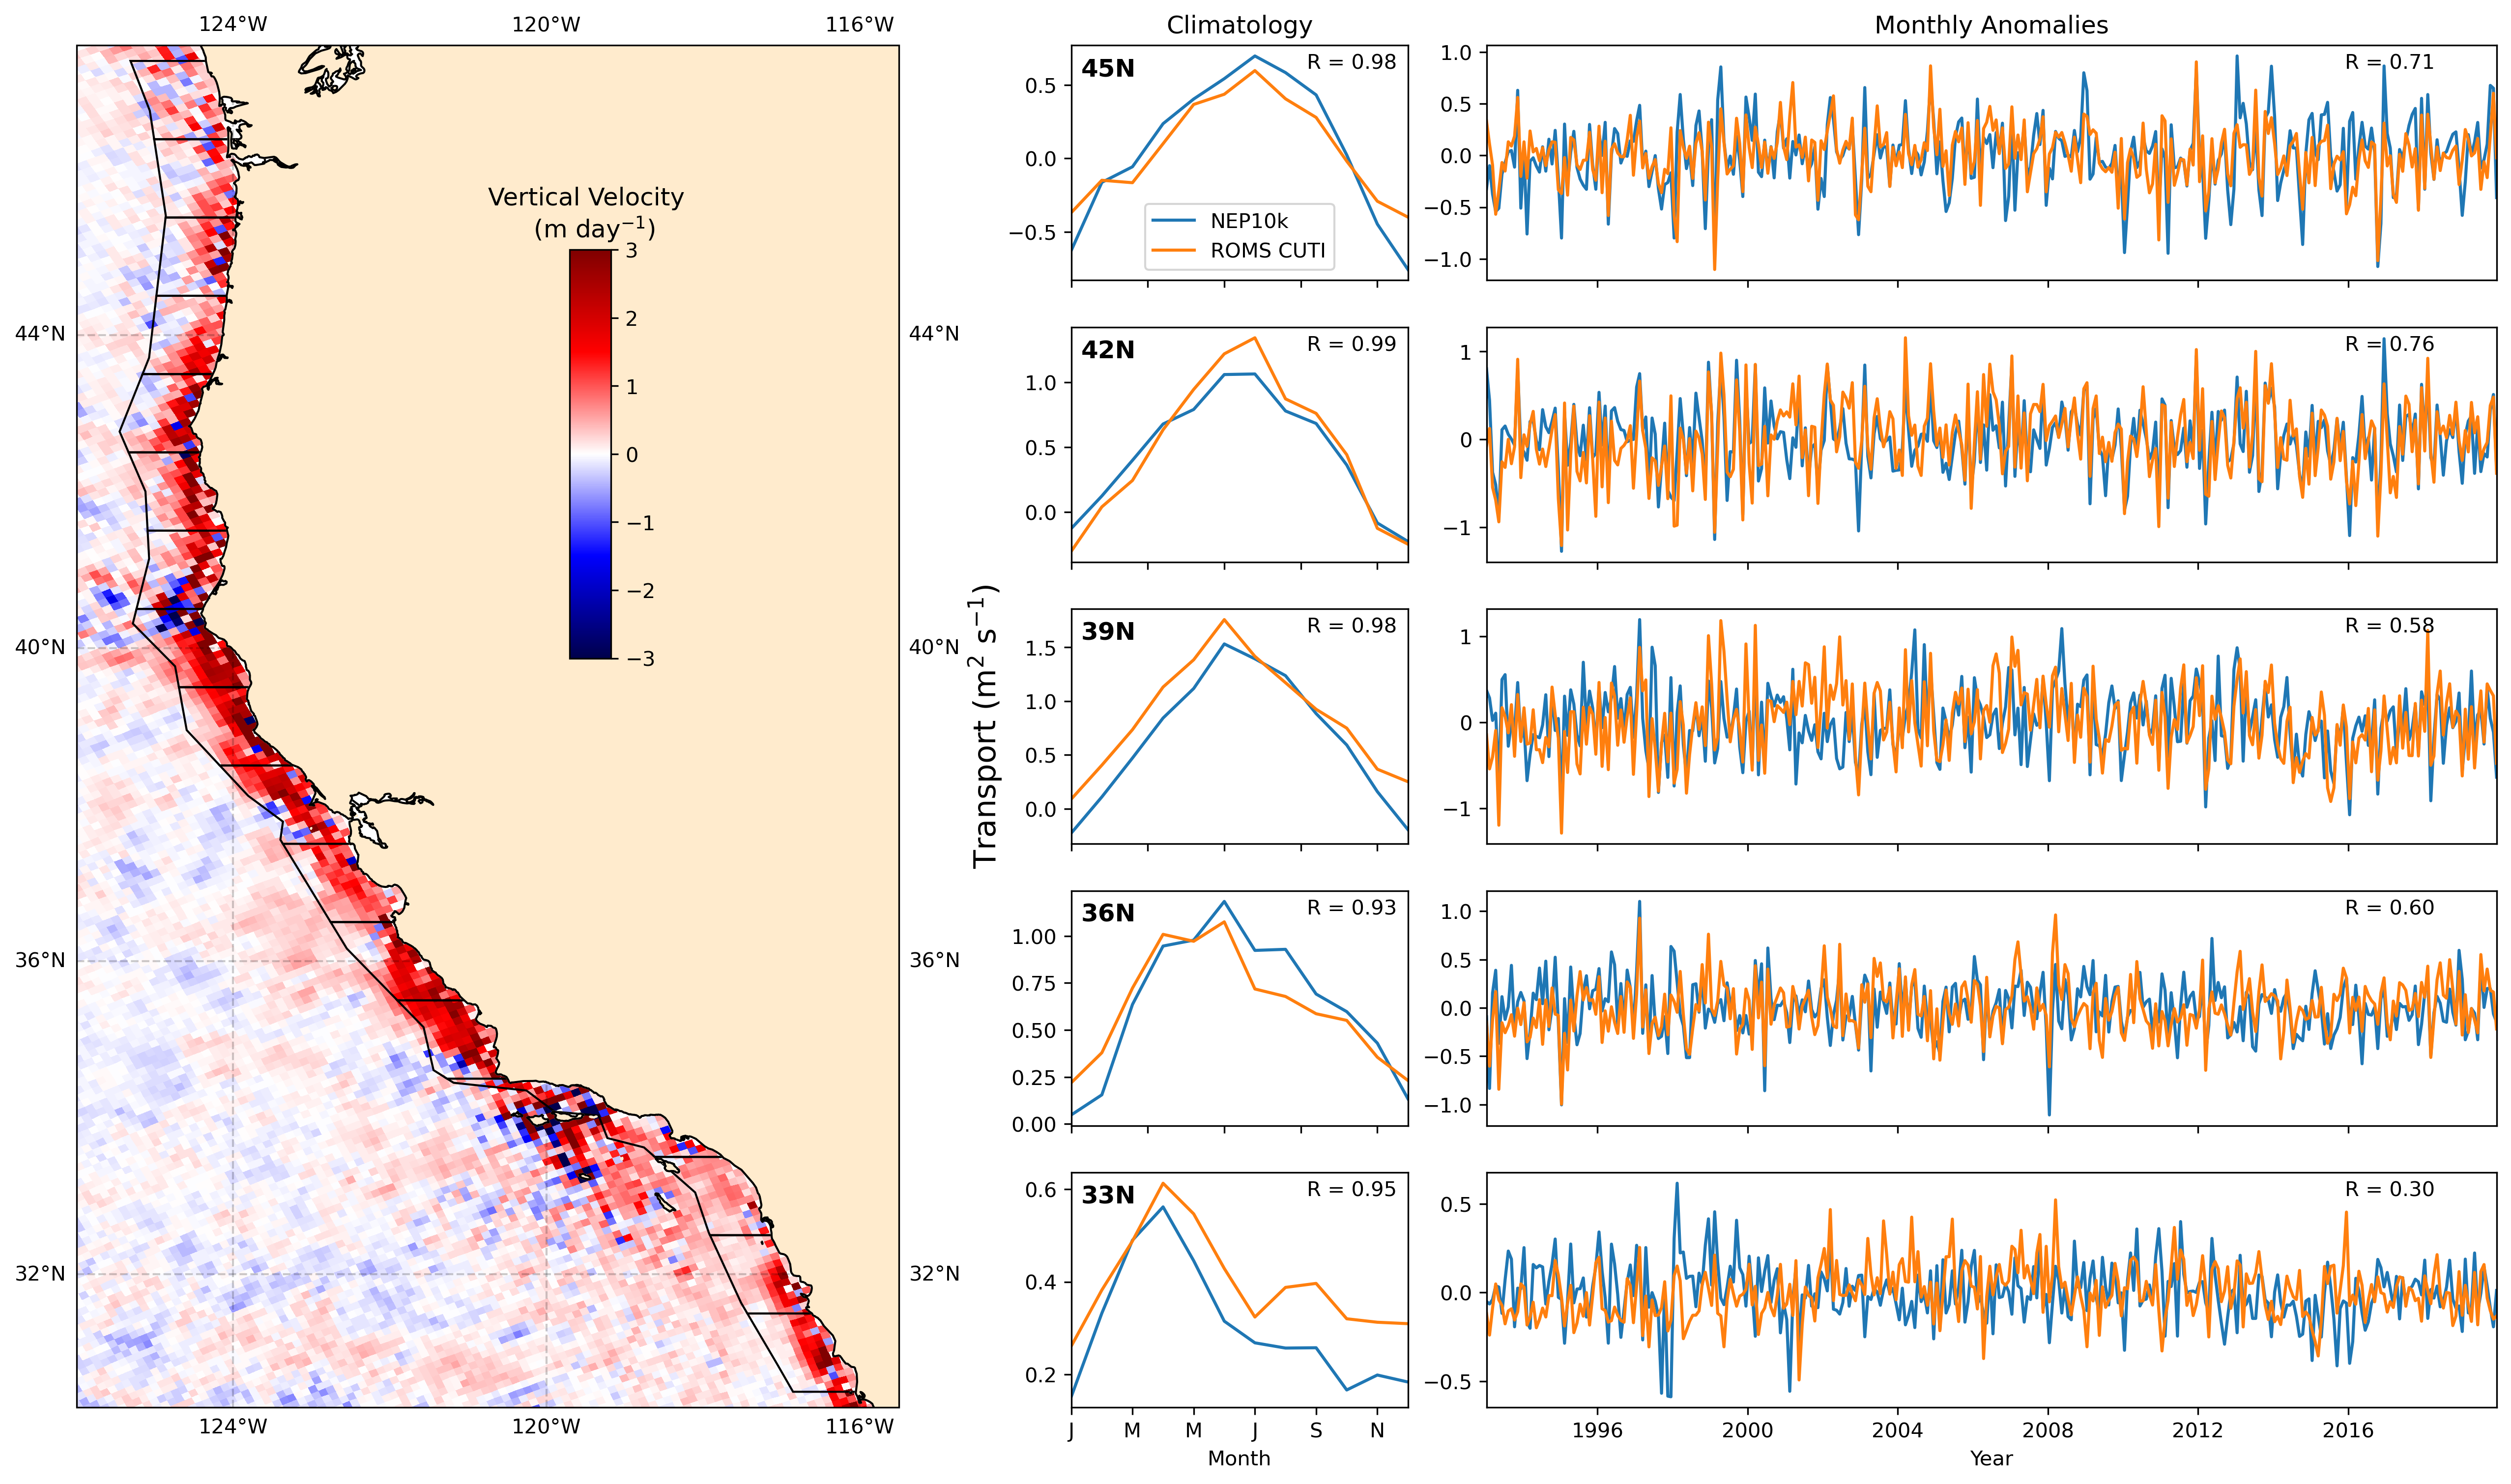

In [15]:
months = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig = plt.figure(figsize=(22,12),dpi=300)
widths = [3,1,3]

plt_clats = np.arange(45,33-3,-3)

spec = fig.add_gridspec(ncols=3, nrows=5,width_ratios=widths,wspace=.1)
    
plt_map()

nplot=0
tmp_cuti_stor = cuti_storage[::-1,:]
for clat, nlat in zip(lat_centers[::-1], range(len(lat_centers))):
    print(clat,nlat)
    if clat in plt_clats:
        plt_clim_ts()
        nplot+=1

plt.savefig(('Figure24_mar-aug_w_at_' + str(z_i[dep_idx]) + 'm_and_CUTI.png'))